# Load Dataset

### Load players df and fixtures df

In [221]:
import pandas as pd
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

def get_player_data():
    players_url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
    response = requests.get(players_url)
    if response.status_code == 200:
        data = response.json()
        players_df = pd.DataFrame(data['elements'])
        return players_df
    else:
        print(f"Failed to retrieve players data: {response.status_code} - {response.text}")
        return None

# Function to fetch fixtures data
def get_fixtures():
    fixtures_url = 'https://fantasy.premierleague.com/api/fixtures/'
    response = requests.get(fixtures_url)
    
    if response.status_code == 200:
        fixtures = pd.DataFrame(response.json())  # Fixture data
        return fixtures
    else:
        print(f"Failed to retrieve fixtures: {response.status_code}")
        return None

# Fetch the data
players_df = get_player_data()
fixtures_df = get_fixtures()


## All Necessary Functions

### Calculate FDR (5 fixtures)

In [224]:
def calculate_average_fdr():
        fixtures_df = get_fixtures()
        # Filter remaining (unfinished) fixtures
        remaining_fixtures = fixtures_df[fixtures_df['finished'] == False]
    
        # Create an empty list to hold FDR values for each team
        fdr_values = []
    
        # Sort the remaining fixtures by date or round to ensure the 5 upcoming are considered
        remaining_fixtures = remaining_fixtures.sort_values(by='kickoff_time')
    
        # Iterate over each team
        for team in set(remaining_fixtures['team_h']).union(set(remaining_fixtures['team_a'])):
            # Get home and away fixtures for this team
            team_fixtures = remaining_fixtures[
                (remaining_fixtures['team_h'] == team) | (remaining_fixtures['team_a'] == team)
            ].head(3)  # Limit to 1 fixtures
    
            # Collect FDR for home and away games
            for idx, fixture in team_fixtures.iterrows():
                if fixture['team_h'] == team:
                    fdr_values.append({'team': team, 'fdr': fixture['team_h_difficulty']})
                elif fixture['team_a'] == team:
                    fdr_values.append({'team': team, 'fdr': fixture['team_a_difficulty']})
    
        # Create a DataFrame from FDR values and calculate average FDR
        fdr_df = pd.DataFrame(fdr_values)
        average_fdr = fdr_df.groupby('team')['fdr'].mean().reset_index()
    
        # Rename columns
        average_fdr.columns = ['team', 'average_fdr']
    
        return average_fdr


In [225]:

def add_average_fdr(players_df):
    # Get average FDR for each team
    average_fdr = calculate_average_fdr()

    # Map team names back to their IDs
    team_mapping = {
        1: 'Arsenal', 2: 'Aston Villa', 3: 'Bournemouth', 4: 'Brentford',
        5: 'Brighton', 6: 'Chelsea', 7: 'Crystal Palace', 8: 'Everton',
        9: 'Fulham', 10: 'Ipswich', 11: 'Leicester', 12: 'Liverpool',
        13: 'Man City', 14: 'Man Utd', 15: 'Newcastle', 16: 'Nottingham Forest',
        17: 'Southampton', 18: 'Spurs', 19: 'West Ham', 20: 'Wolves'
    }
    
    # Map team names
    average_fdr['team_name'] = average_fdr['team'].map(team_mapping)
    
    # Invert the average FDR
    max_fdr = average_fdr['average_fdr'].max()
    average_fdr['adjusted_fdr'] = 7 - average_fdr['average_fdr']
    
    # Sort teams by adjusted FDR
    # sorted_fdr = average_fdr.sort_values(by='adjusted_fdr', ascending=False)

    # Merge adjusted FDR back to players_df
    # players_df = players_df.merge(average_fdr[['team', 'adjusted_fdr']], how='left', on='team', suffixes=('', '_avg'))
    players_df = players_df.merge(average_fdr[['team', 'adjusted_fdr','average_fdr']], how='left', on='team', suffixes=('', '_avg'))
    # players_df = players_df.merge(average_fdr, how='left', left_on='team', right_on='team')

    # Check for and drop any duplicates
    players_df = players_df.loc[:, ~players_df.columns.duplicated()]
    return players_df



# Data preprocessing:

## Data Cleaning

### Check for missing values:

In [229]:
import pandas as pd

# Assuming players_df and fixtures_df are already defined
missing_values_players = players_df.isnull().sum()
missing_values_fixtures = fixtures_df.isnull().sum()

missing_values_summary = {
    'players_df_missing_values': missing_values_players[missing_values_players > 0],
    'fixtures_df_missing_values': missing_values_fixtures[missing_values_fixtures > 0]
}

print(missing_values_summary)


{'players_df_missing_values': chance_of_playing_next_round            301
chance_of_playing_this_round            302
news_added                              301
squad_number                            670
region                                  113
corners_and_indirect_freekicks_order    604
direct_freekicks_order                  615
penalties_order                         622
dtype: int64, 'fixtures_df_missing_values': team_a_score    283
team_h_score    283
dtype: int64}


In [230]:
players_df.transfers_in

0          439
1        54300
2      2113259
3      1965093
4            0
        ...   
665       5358
666      22858
667       2441
668       1579
669      14509
Name: transfers_in, Length: 670, dtype: int64

#### Handling missing values for players df

In [232]:
# Dropping irrelevant columns from players_df
irrelevant_columns_players = [
    'squad_number',
    'region',
    'corners_and_indirect_freekicks_order',
    'chance_of_playing_this_round',
    'news_added',
    'chance_of_playing_next_round',
    'code', 'first_name', 'second_name', 'photo', 'news','direct_freekicks_text','penalties_text','transfers_in','transfers_out'
]

# These columns are not important because we have other columns in the dataset that tells the same thing. 

players_df_cleaned = players_df.drop(columns=irrelevant_columns_players, errors='ignore')

let's inspect direct_freekicks_order and penalties_order .. they are crucial for prediction

In [234]:

# Replace 'column_name' with the name of the column you want to check
print(players_df_cleaned['direct_freekicks_order'].unique())

print(players_df_cleaned['penalties_order'].unique())

[nan  1.  2.  4.  3.]
[nan  3.  2.  1.  4.]


Fill out nan with 0 because they are non relevant. We might have to think in the future how to give importance to 2 when 1 is injured..

In [236]:
# Replace NaN values in 'direct_freekick_order' and 'penalties_order' with 0
players_df_cleaned['direct_freekicks_order'] = players_df_cleaned['direct_freekicks_order'].fillna(0)
players_df_cleaned['penalties_order'] = players_df_cleaned['penalties_order'].fillna(0)

In [237]:
# Assuming the original status values are 'i' for injured, 'u' for unavailable, and 'a' for available
players_df = players_df[~players_df['status'].isin(['i', 'u'])]

Let's inspect fixtures_df to see whether the team_h_score and team_a_score have what sort of missing values.(home goals and away goals)

In [239]:
# Filter rows where either team_h_score or team_a_score is null
missing_scores_df = fixtures_df[(fixtures_df['team_h_score'].isnull()) | (fixtures_df['team_a_score'].isnull())]

Given the information, it's future fixtures so we leave this as NaN for now. We don't delete this because we need to calculate average fdr later. 

In [304]:
# Feature engineer players value through totalpoint/cost

In [300]:
players_df_cleaned['value'] = players_df_cleaned['total_points'] / players_df_cleaned['now_cost']

## EDA and feature selection:

In [306]:
players_df_cleaned.columns

Index(['cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'form', 'id', 'in_dreamteam', 'now_cost',
       'points_per_game', 'selected_by_percent', 'special', 'status', 'team',
       'team_code', 'total_points', 'transfers_in_event',
       'transfers_out_event', 'value_form', 'value_season', 'web_name',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded',
       'influence_rank', 'influence_rank_type', 'creativity_rank',
       'creativity_rank_type', 'threat_rank', 'threat_rank_type',
       'ict_index_rank', 'ict_index_rank_type',
       'corne

In [243]:
import pandas as pd

# Set the display option to show all columns
pd.set_option('display.max_columns', None)

# Now when you print the DataFrame, all columns will be shown
print(players_df_cleaned.head())


   cost_change_event  cost_change_event_fall  cost_change_start  \
0                  0                       0                 -1   
1                  0                       0                 -2   
2                  0                       0                  2   
3                  0                       0                  1   
4                  0                       0                  0   

   cost_change_start_fall  dreamteam_count  element_type ep_next ep_this  \
0                       1                0             3     0.0     0.0   
1                       2                0             4     1.3     1.8   
2                      -2                1             2     2.0     1.9   
3                      -1                1             4     3.7     4.2   
4                       0                0             1     0.0     0.0   

   event_points form  id  in_dreamteam  now_cost points_per_game  \
0             0  0.0   1         False        54             0.0   
1   

Label Encoding of status columns (which shows the status of the player whether they are injured or not

In [308]:
# Step 2: Label encoding for the 'status' column
if 'status' in players_df.columns:
    le = LabelEncoder()
    players_df_cleaned['status'] = le.fit_transform(players_df_cleaned['status'])

Convert  to numeric all columns

In [247]:
import pandas as pd

# Assuming players_df_cleaned is your DataFrame
# Filter for object (dtype('O')) and boolean (dtype('bool')) columns
object_bool_columns = players_df_cleaned.select_dtypes(include=['object', 'bool'])

# Print the filtered columns
print(object_bool_columns)


    ep_next ep_this form  in_dreamteam points_per_game selected_by_percent  \
0       0.0     0.0  0.0         False             0.0                 0.0   
1       1.3     1.8  0.8         False             0.6                 0.9   
2       2.0     1.9  1.5         False             4.3                22.7   
3       3.7     4.2  3.2         False             4.5                15.1   
4       0.0     0.0  0.0         False             0.0                 0.0   
..      ...     ...  ...           ...             ...                 ...   
665     0.7     0.2  0.2         False             0.6                 0.2   
666     0.2     0.0  0.0         False             0.0                 0.2   
667     1.3     0.8  0.8         False             1.1                 0.0   
668     1.3     0.8  0.8         False             0.8                 0.0   
669     0.5     0.0  0.0         False             0.0                 0.1   

     special value_form value_season      web_name influence cr

In [310]:

# Convert boolean columns to integers (True -> 1, False -> 0)
bool_columns = players_df_cleaned.select_dtypes(include=['bool']).columns
players_df_cleaned[bool_columns] = players_df_cleaned[bool_columns].astype(int)

# Convert object columns to numeric (if applicable)
# This will convert the strings to NaN if they can't be converted to numbers
object_columns = players_df_cleaned.select_dtypes(include=['object']).columns
players_df_cleaned[object_columns] = players_df_cleaned[object_columns].apply(pd.to_numeric, errors='coerce')


Apply Variance to see the best informative features

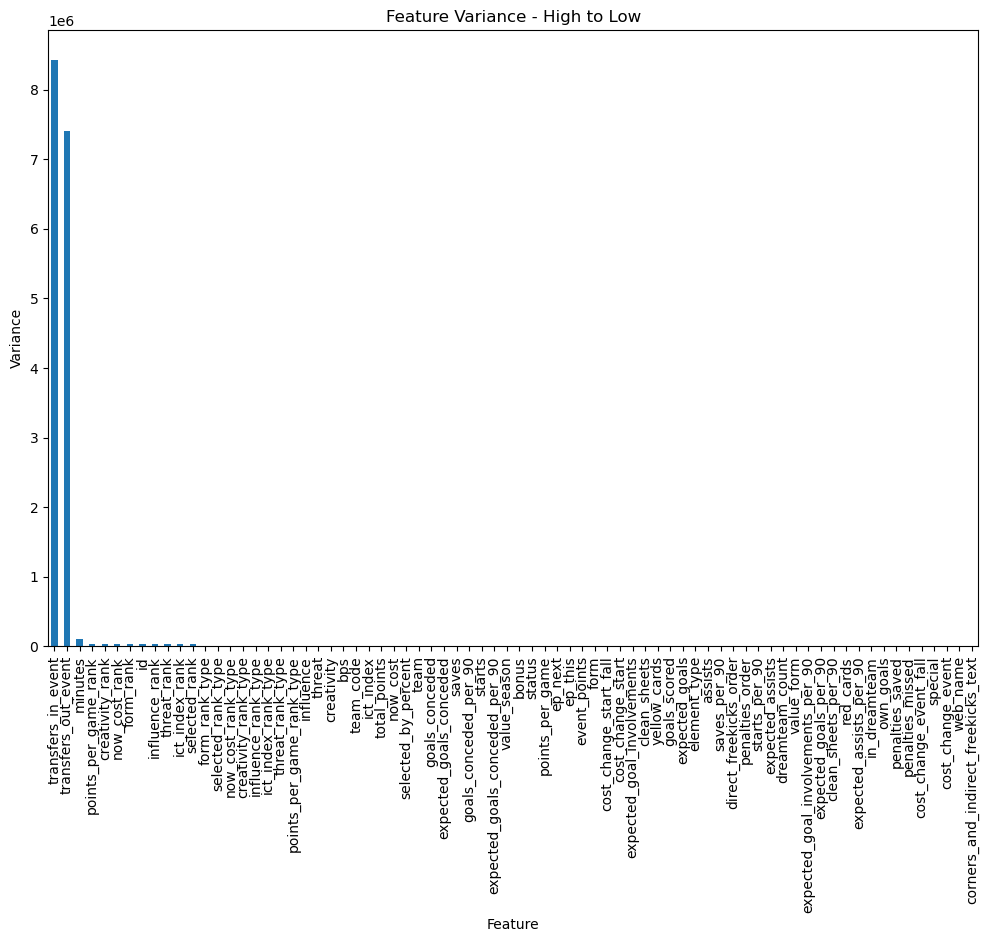

Selected high-variance features:
 ['cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'form', 'in_dreamteam', 'now_cost', 'points_per_game', 'selected_by_percent', 'status', 'team', 'team_code', 'total_points', 'transfers_in_event', 'transfers_out_event', 'value_form', 'value_season', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'starts', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'influence_rank', 'influence_rank_type', 'creativity_rank', 'creativity_rank_type', 'threat_rank', 'threat_rank_type', 'ict_index_rank', 'ict_index_rank_type', 'direct_freekicks_order', 'penalties_order', 'expected_goals_per_90', 'saves_per_90', 'expected_assists_per_90', 'expected_goal_involvements_per_90', 'e

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_variance_threshold.py:119: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


In [312]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

# Select only the numerical columns
data = players_df_cleaned.select_dtypes(include=['float64', 'int64']) 

# Calculate the variance for each feature
variances = data.var()


# Sort the features by variance in descending order
sorted_variances = variances.sort_values(ascending=False)

# Plot the features in order of high variance to low
plt.figure(figsize=(12, 8))
sorted_variances.plot(kind='bar')
plt.title('Feature Variance - High to Low')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

# Apply VarianceThreshold to filter features with low variance
# Set the variance threshold (e.g., 3000); you can adjust this value as needed
selector = VarianceThreshold(threshold=0)
selector.fit(data)

# Get the feature names that are kept after applying VarianceThreshold
high_variance_columns = data.columns[selector.get_support()]

# Filter out 'id' or any other irrelevant features
high_variance_columns = [col for col in high_variance_columns if col != 'id']

# Print the selected high-variance features
print("Selected high-variance features:\n", high_variance_columns)

# Selecting features with higher variance
data = data[high_variance_columns]

# Sort the high variance columns based on their variance values in descending order
high_variance_sorted = sorted_variances[high_variance_columns].sort_values(ascending=False)

# Print the sorted high-variance features
print("\nSorted High-Variance Features:\n", high_variance_sorted)

#Selecting features with higher variance
data = data[high_variance_sorted.index]



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


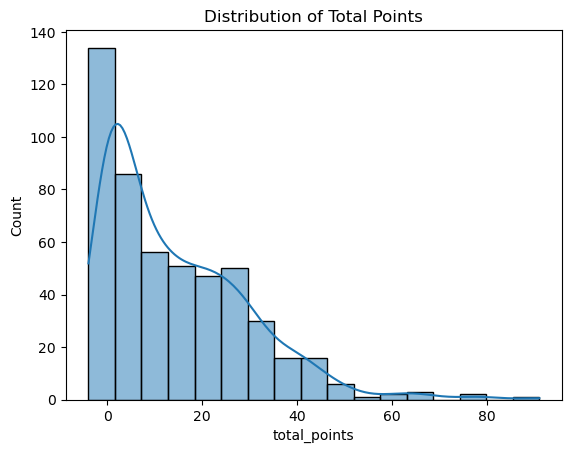

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(players_df['total_points'], kde=True)
plt.title("Distribution of Total Points")
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


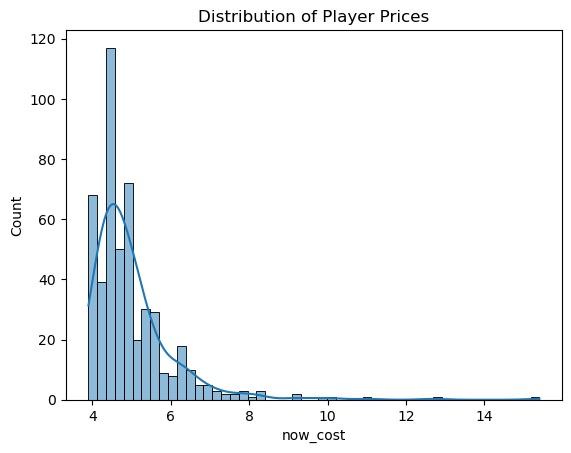

In [252]:
sns.histplot(players_df['now_cost']/10, kde=True)
plt.title("Distribution of Player Prices")
plt.show()


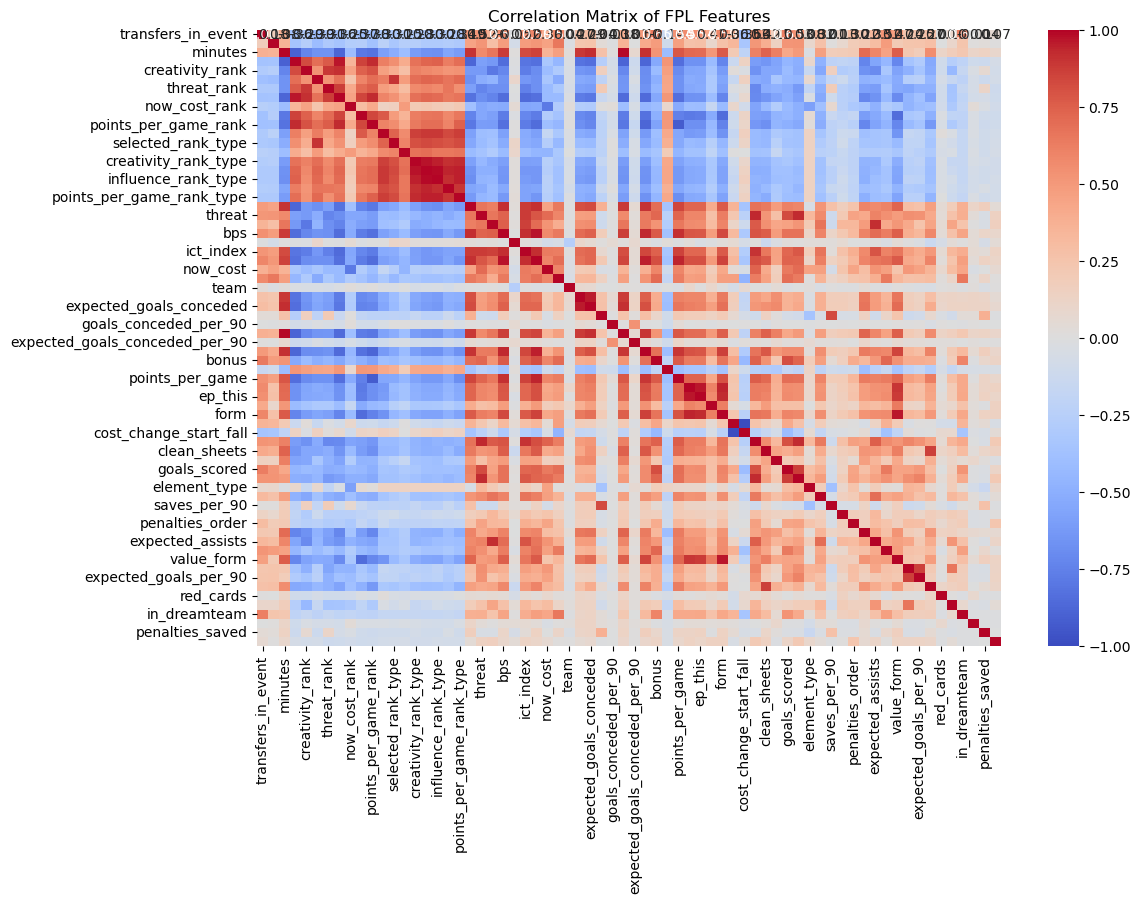

In [253]:
corr = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of FPL Features")
plt.show()


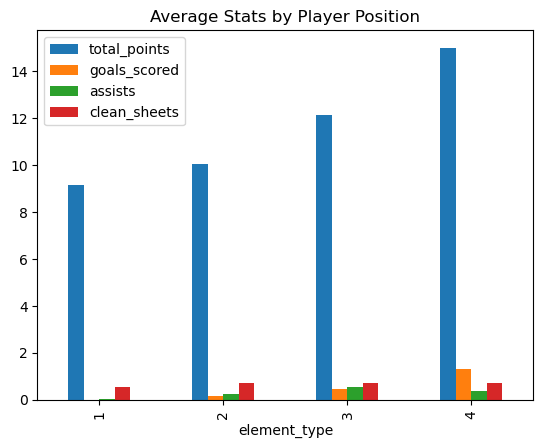

In [254]:
position_means = data.groupby('element_type').mean()
position_means[['total_points', 'goals_scored', 'assists', 'clean_sheets']].plot(kind='bar')
plt.title("Average Stats by Player Position")
plt.show()


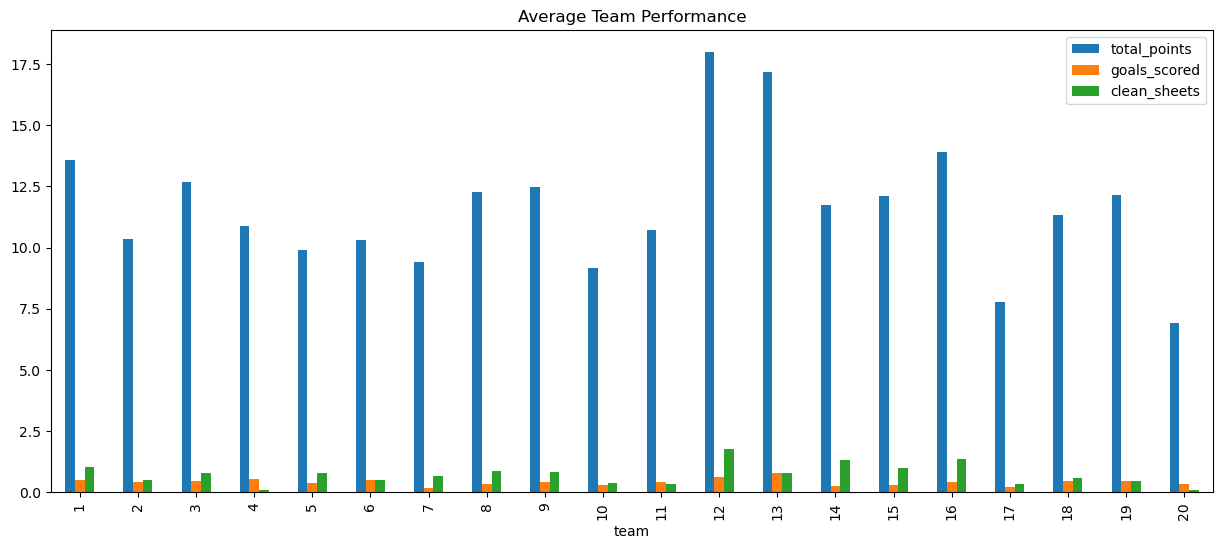

In [292]:
team_means = data.groupby('team').mean()
team_means[['total_points', 'goals_scored', 'clean_sheets']].plot(kind='bar', figsize=(15, 6))
plt.title("Average Team Performance")
plt.show()

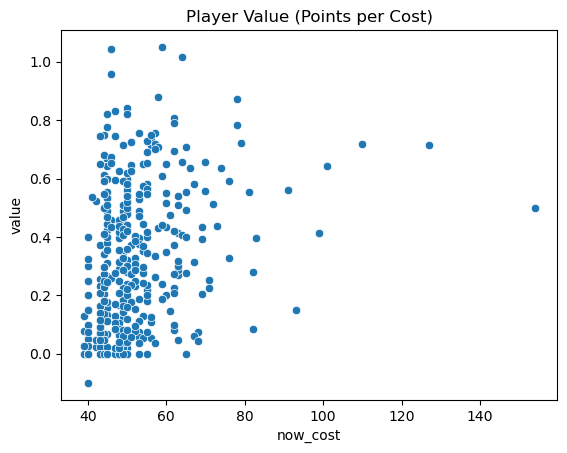

In [298]:
players_df['value'] = players_df['total_points'] / players_df['now_cost']
sns.scatterplot(x='now_cost', y='value', data=players_df)
plt.title("Player Value (Points per Cost)")
plt.show()


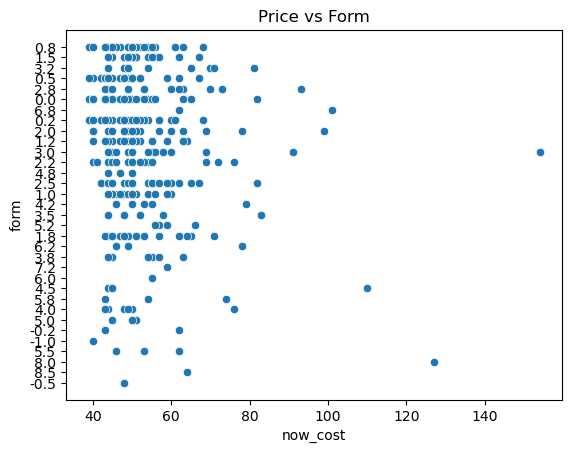

In [314]:
sns.scatterplot(x='now_cost', y='form', data=players_df)
plt.title("Price vs Form")
plt.show()


ValueError: Could not interpret input 'adjusted_fdr'

### Data Scaling using min/max


In [256]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming 'data' is your DataFrame containing the selected high-variance features
# Here 'data' should include only the high-variance features selected previously

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the selected features
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Display the scaled DataFrame
print("Scaled DataFrame:\n", data_scaled_df)


Scaled DataFrame:
      transfers_in_event  transfers_out_event   minutes  influence_rank  \
0              0.000000             0.000063  0.000000        0.979073   
1              0.002506             0.009091  0.124444        0.523169   
2              0.066970             0.337517  0.958889        0.049327   
3              0.028031             0.600736  1.000000        0.052317   
4              0.000000             0.000157  0.000000        0.714499   
..                  ...                  ...       ...             ...   
665            0.000393             0.000881  0.672222        0.252616   
666            0.000025             0.001384  0.000000        0.748879   
667            0.000369             0.000409  0.402222        0.385650   
668            0.000590             0.000315  0.201111        0.512706   
669            0.000565             0.001667  0.000000        0.741405   

     creativity_rank  selected_rank  threat_rank  ict_index_rank  \
0           0.977578    

##  PCA

In [258]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)  # You can adjust the number of components
data_pca = pca.fit_transform(data_scaled_df)

In [259]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)  # Output will show the proportion of variance explained by each principal component

# Store the explained variance ratios into two variables
explained_variance_pc1 = round(pca.explained_variance_ratio_[0],2)  # Variance for PC1
explained_variance_pc2 = round(pca.explained_variance_ratio_[1],2)  # Variance for PC2
print(explained_variance_pc1) 

[0.52587061 0.08757932]
0.53


#### Checking for non-linearity to assign pca score

In [261]:
import pandas as pd

# Assume total_points is a Series containing the total points for each player
total_points = players_df['total_points']  # Replace with your actual column name

# Create a new DataFrame
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])
pca_df['Total Points'] = total_points


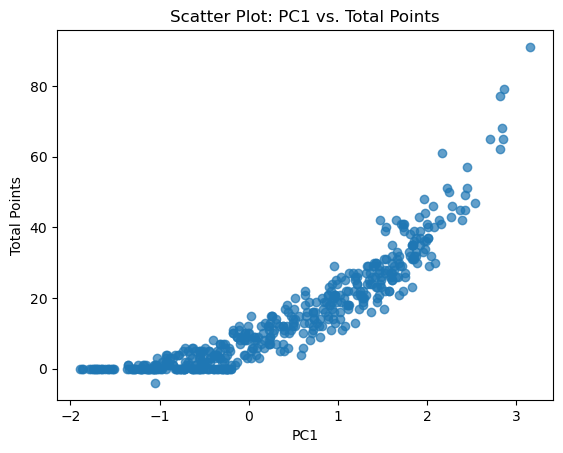

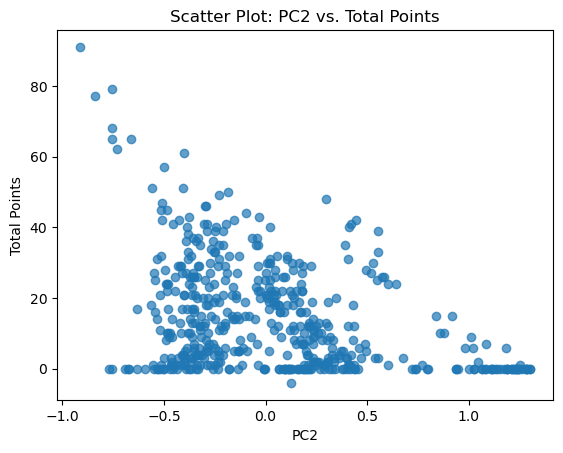

In [262]:
import matplotlib.pyplot as plt

# Scatter plot for PC1 vs. Total Points
plt.scatter(pca_df['PC1'], pca_df['Total Points'], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('Total Points')
plt.title('Scatter Plot: PC1 vs. Total Points')
plt.show()

# Scatter plot for PC2 vs. Total Points
plt.scatter(pca_df['PC2'], pca_df['Total Points'], alpha=0.7)
plt.xlabel('PC2')
plt.ylabel('Total Points')
plt.title('Scatter Plot: PC2 vs. Total Points')
plt.show()


In [263]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assuming pca_df contains PC1, PC2, and Total Points

# Step 1: Remove rows with NaN values in 'PC1' and 'Total Points'
pca_df_cleaned = pca_df.dropna(subset=['PC1', 'Total Points'])

X = pca_df_cleaned[['PC1']]
y = pca_df_cleaned['Total Points']

# Step 2: Transform PC1 to polynomial features
poly = PolynomialFeatures(degree=2)  # You can change the degree as needed
X_poly = poly.fit_transform(X)

# Step 3: Fit a polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Get predictions and calculate R² score
poly_predictions = poly_model.predict(X_poly)
poly_r2 = r2_score(y, poly_predictions)

# Fit a linear regression model for comparison
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_predictions = linear_model.predict(X)
linear_r2 = r2_score(y, linear_predictions)

# Step 4: Determine non-linearity based on R² scores
# If polynomial R² is significantly higher than linear R², we consider it non-linear
threshold = 0.01  # Adjust threshold based on your criteria
non_linearity = 1 if (poly_r2 - linear_r2 > threshold) else 0

# Print results
print(f'Polynomial R²: {poly_r2}')
print(f'Linear R²: {linear_r2}')
print(f'Non-linearity for PC1: {non_linearity}')


Polynomial R²: 0.9280384556443778
Linear R²: 0.8274299920736911
Non-linearity for PC1: 1


### Handling non-linear relationship

Given the exponential relationship with total points, consider transforming PC1 using a logarithmic or polynomial transformation. This can help capture the non-linear relationship while still using a regression framework.

In [266]:

non_linearity_pc1 = 1 if poly_r2 > linear_r2 else 0

# Step 4: Calculate Scores based on non-linearity
if non_linearity_pc1 == 1:
    # PC1 is non-linear; use polynomial features
    poly = PolynomialFeatures(degree=2)  # Adjust degree as needed
    poly_features = poly.fit_transform(pca_df[['PC1']])  # This will include the constant term

    # Add polynomial features to the DataFrame
    pca_df[['PC1', 'PC1^2']] = poly_features[:, 1:]  # Ignore the first column (constant)

    # Calculate Score using polynomial feature of PC1 and original PC2
    players_df['Score'] = (explained_variance_pc1 * pca_df['PC1^2']) + (explained_variance_pc2 * pca_df['PC2'])
else:
    # PC1 is linear; use original PC1
    players_df['Score'] = (explained_variance_pc1 * pca_df['PC1']) + (explained_variance_pc2 * pca_df['PC2'])


Check:

In [268]:
# Step 5: Sort players_df by Score in descending order and print 'web_name' and 'Score'
sorted_players_df = players_df[['web_name', 'Score']].sort_values(by='Score', ascending=False)

# Display the sorted DataFrame
print(sorted_players_df)

    web_name     Score
392  M.Salah  5.199491
207   Palmer  4.270323
13      Saka  4.232206
113   Mbeumo  4.191484
167  Welbeck  4.133522
..       ...       ...
109   Jensen -0.033316
605  Álvarez -0.034156
370    Skipp -0.035744
308    Berge -0.037561
667    André -0.043978

[501 rows x 2 columns]


## K-means clustering

Elbow Method

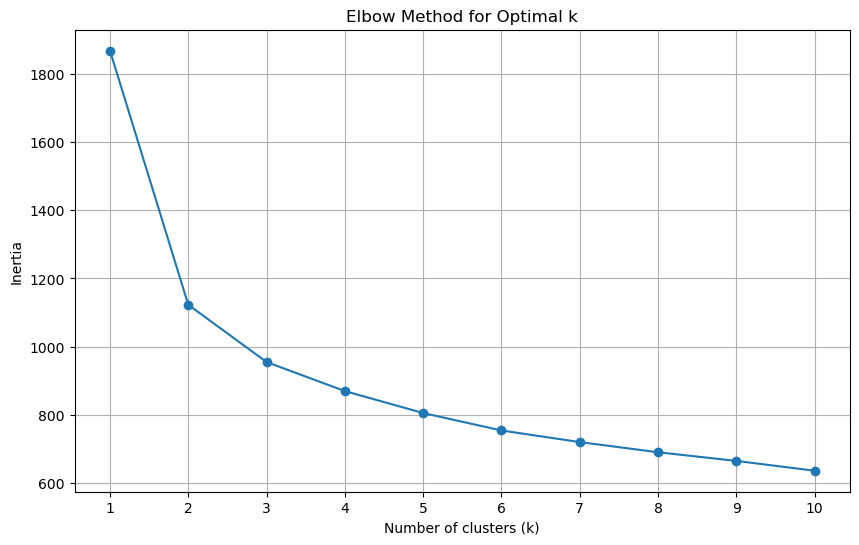

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 3: Fit K-means for a range of clusters
inertia = []  # To store the inertia values
k_values = range(1, 11)  # Adjust the range based on your needs

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)  # Using random_state for reproducibility
    kmeans.fit(data_scaled_df)  # Fit the model
    inertia.append(kmeans.inertia_)  # Store the inertia value

# Step 5: Plot the Inertia vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()


The optimal cluster is 2. And we know it's the best players cluster and worst players cluster. 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


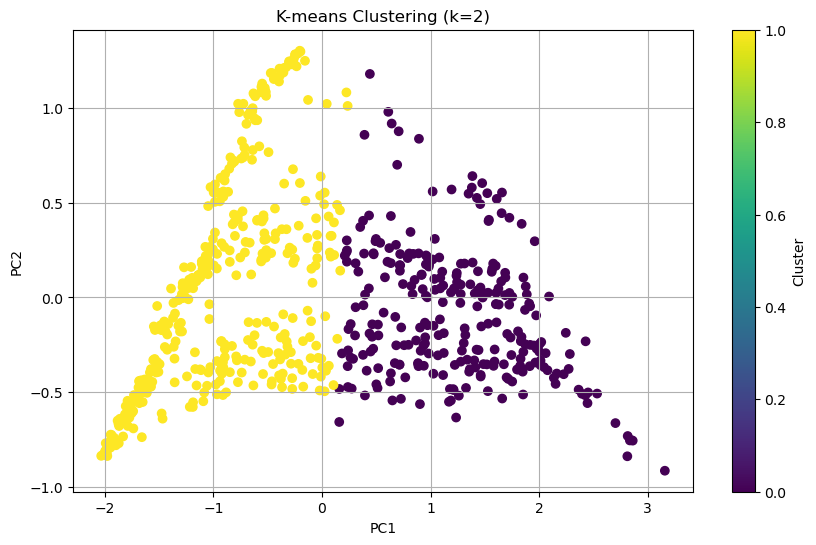

Cluster Centroids:
[[ 1.24389159 -0.09053246]
 [-0.88758505  0.06459989]]


In [273]:
# Step 3: Fit K-means with the optimal number of clusters (k=2)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)  # Using random_state for reproducibility
if non_linearity_pc1:
    kmeans.fit(pca_df[['PC1', 'PC2']])  # Fit the model
else:
    kmeans.fit(pca_df[['PC1','PC1^2', 'PC2']])  # Fit the model


# Step 4: Add cluster labels to your original DataFrame
pca_df['Cluster'] = kmeans.labels_

# Step 5: Visualize the clusters (if applicable)
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering (k=2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

# Optional: Print the centroids
centroids = kmeans.cluster_centers_
print("Cluster Centroids:")
print(centroids)

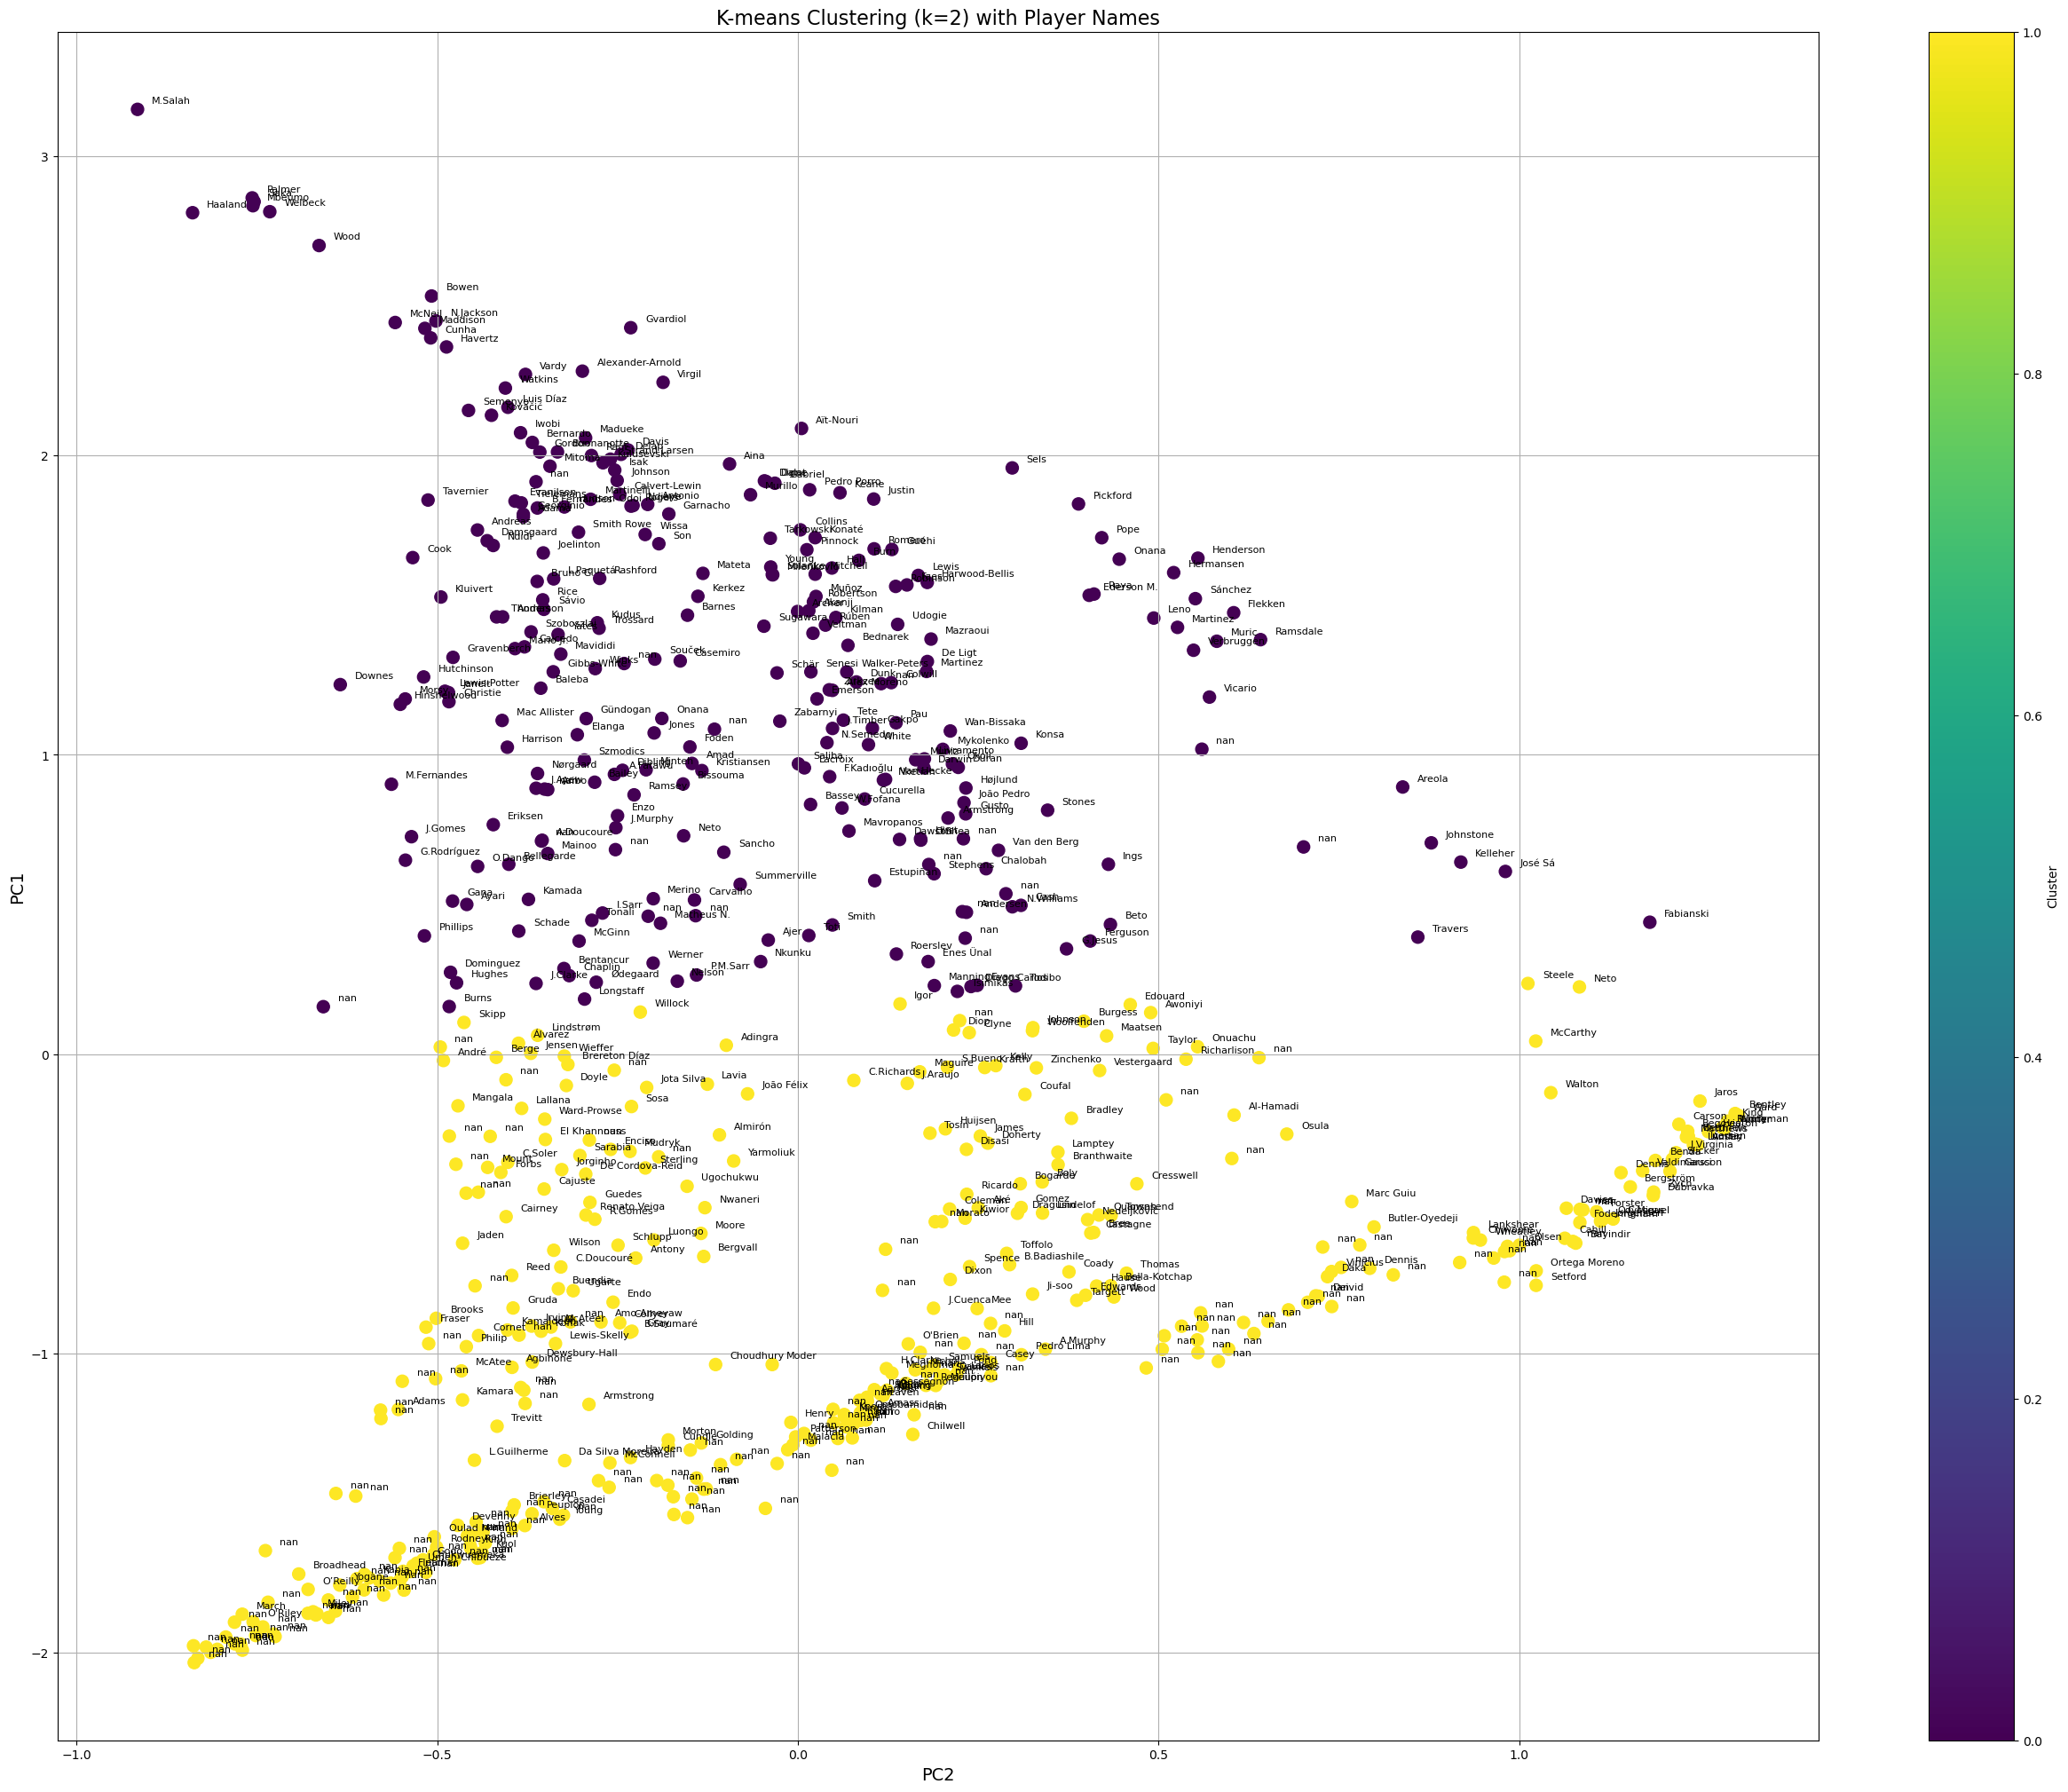

In [274]:
import matplotlib.pyplot as plt

# Assuming `web_name` is a column in the `players_df`
# Make sure 'web_name' is available in your DataFrame
pca_df['web_name'] = players_df['web_name']  # Add the player names to the PCA DataFrame

# Step 7: Visualize the clusters with player names annotated
plt.figure(figsize=(32, 25))  # Increase the size here (width, height)
scatter = plt.scatter(pca_df['PC2'], pca_df['PC1'], c=pca_df['Cluster'], cmap='viridis', marker='o', s=100)

# Add player names next to the scatter points
for i, player_name in enumerate(pca_df['web_name']):
    plt.text(pca_df['PC2'][i] + 0.02, pca_df['PC1'][i] + 0.02, player_name, fontsize=8)

# Add labels and title
plt.title('K-means Clustering (k=2) with Player Names', fontsize=16)  # Increase title font size
plt.xlabel('PC2', fontsize=14)  # Change x-label to PC2
plt.ylabel('PC1', fontsize=14)  # Change y-label to PC1
plt.colorbar(label='Cluster')

# Display the plot
plt.grid()
plt.show()


In [275]:
import numpy as np

# Step 1: Add cluster labels to pca_df and calculate average 'PC1' for each cluster
# pca_df['Cluster'] = data_scaled_df['Cluster']

# Step 2: Calculate the average 'PC1' value for each cluster (you can use 'Total Points' or other metric)
cluster_avg = pca_df.groupby('Cluster')['PC1'].mean()

# Step 3: Identify the worst cluster (lowest average 'PC1' score)
worst_cluster = cluster_avg.idxmin()  # Get the cluster with the lowest average 'PC1'

# Use .loc to filter players_df based on the clusters in pca_df
players_df_filtered = players_df.loc[pca_df['Cluster'] != worst_cluster]

# Sort the filtered players_df by Score in descending order
players_df_filtered_sorted = players_df_filtered.sort_values(by='Score', ascending=False)

# Display the sorted DataFrame
print(players_df_filtered_sorted[['web_name', 'Score']])



      web_name     Score
392    M.Salah  5.199491
207     Palmer  4.270323
13        Saka  4.232206
113     Mbeumo  4.191484
167    Welbeck  4.133522
..         ...       ...
340   J.Clarke -0.003161
508  Dominguez -0.003787
484  Longstaff -0.008730
230     Hughes -0.012537
313      Burns -0.030140

[262 rows x 2 columns]


In [276]:
players_df_filtered = add_average_fdr(players_df_filtered)

In [277]:
players_df_filtered[['adjusted_fdr']].head()

,adjusted_fdr
0,3.333333
1,3.333333
2,3.333333
3,3.333333
4,3.333333


In [278]:

# Calculate the new score
# Set the weight for adjusted_fdr
weight = 0.1  # Adjust this value based on how much you want to influence the score

# Calculate the new score
players_df_filtered['adjusted_score'] = players_df_filtered['Score'] + (weight * players_df_filtered['adjusted_fdr'])

# Optional: Display the updated DataFrame to check the new scores
print(players_df_filtered[['Score', 'adjusted_fdr', 'adjusted_score']].head())

# Sort the filtered players_df by Score in descending order
players_df_filtered_sorted = players_df_filtered.sort_values(by='Score', ascending=False)

# Display the sorted DataFrame
print(players_df_filtered_sorted[['web_name', 'Score']])

# Continue to map positions and get top players

# Position mapping
position_mapping = {1: 'goalkeeper', 2: 'defender', 3: 'midfielder', 4: 'forward'}
players_df_filtered_sorted['position'] = players_df_filtered_sorted['element_type'].map(position_mapping)

players_df_filtered_sorted = add_average_fdr(players_df_filtered_sorted)

# Rank players based on PCA score from the filtered dataframe
top_goalkeepers = players_df_filtered_sorted[players_df_filtered_sorted['position'] == 'goalkeeper']\
                    .nlargest(15, 'adjusted_score')[['id', 'web_name', 'adjusted_score', 'now_cost', 'influence', 'average_fdr', 'minutes']]

top_defenders = players_df_filtered_sorted[players_df_filtered_sorted['position'] == 'defender']\
                    .nlargest(15, 'adjusted_score')[['id', 'web_name', 'adjusted_score', 'now_cost', 'influence', 'average_fdr', 'minutes' ]]

top_midfielders = players_df_filtered_sorted[players_df_filtered_sorted['position'] == 'midfielder']\
                    .nlargest(15, 'adjusted_score')[['id', 'web_name', 'adjusted_score', 'now_cost', 'influence', 'average_fdr', 'minutes']]

top_forwards = players_df_filtered_sorted[players_df_filtered_sorted['position'] == 'forward']\
                    .nlargest(20, 'adjusted_score')[['id', 'web_name', 'adjusted_score', 'now_cost', 'influence', 'average_fdr', 'minutes']]


# # Return top players
# return top_goalkeepers, top_defenders, top_midfielders, top_forwards

# Display results
print("Top Goalkeepers:")
print(top_goalkeepers)

print("\nTop Defenders:")
print(top_defenders)

print("\nTop Midfielders:")
print(top_midfielders)

print("\nTop Forwards:")
print(top_forwards)


      Score  adjusted_fdr  adjusted_score
0  0.099040      3.333333        0.432373
1  1.925695      3.333333        2.259028
2  2.915400      3.333333        3.248733
3  0.631855      3.333333        0.965188
4  1.795693      3.333333        2.129027
      web_name     Score
150    M.Salah  5.199491
78      Palmer  4.270323
8         Saka  4.232206
47      Mbeumo  4.191484
66     Welbeck  4.133522
..         ...       ...
129   J.Clarke -0.003161
200  Dominguez -0.003787
193  Longstaff -0.008730
87      Hughes -0.012537
118      Burns -0.030140

[262 rows x 2 columns]
Top Goalkeepers:
      id    web_name  adjusted_score  now_cost influence  average_fdr  minutes
31   443        Sels        2.426797        46     205.0     3.333333      900
45   235    Pickford        2.326121        49     223.0     2.000000      900
59   413        Pope        2.015873        50     288.4     3.000000      900
70   201   Henderson        1.938588        44     229.2     2.666667      830
72   383    

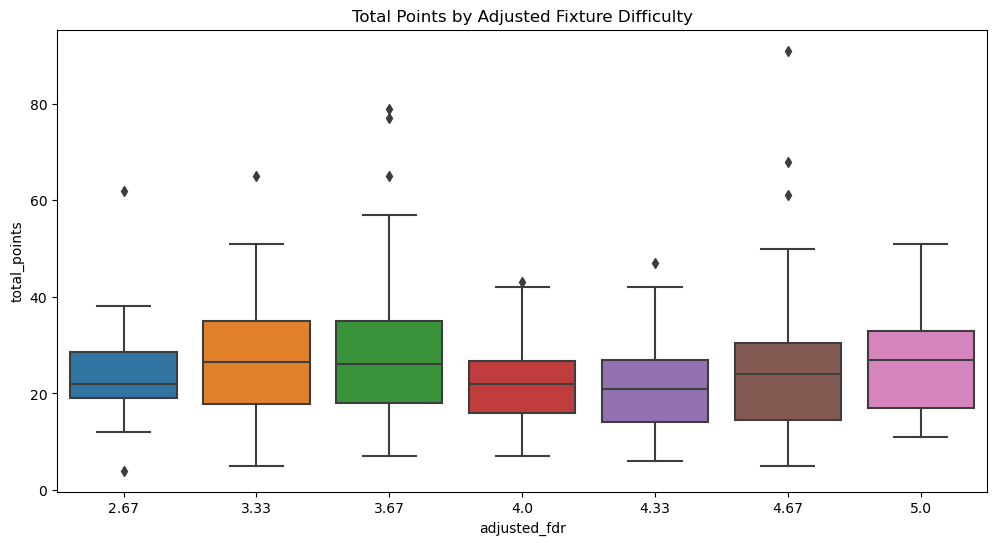

In [332]:
# Round the 'adjusted_fdr' column to 2 decimal places
players_df_filtered['adjusted_fdr'] = players_df_filtered['adjusted_fdr'].round(2)

# Set the figure size (width, height)
plt.figure(figsize=(12, 6))

# Create the boxplot
sns.boxplot(x='adjusted_fdr', y='total_points', data=players_df_filtered)

# Add title and show the plot
plt.title("Total Points by Adjusted Fixture Difficulty")
plt.show()


Fluctuate Score on the basis of fixture difficulty:

Best wildcard team:

In [281]:
import pandas as pd

# Assuming the data for goalkeepers, defenders, midfielders, and forwards is already loaded into DataFrames:
# top_goalkeepers, top_defenders, top_midfielders, top_forwards

# Combine all players into a single DataFrame with a "position" column for easier processing
top_goalkeepers['position'] = 'Goalkeeper'
top_defenders['position'] = 'Defender'
top_midfielders['position'] = 'Midfielder'
top_forwards['position'] = 'Forward'

# Create a dictionary of DataFrames sorted by score-to-cost ratio for each position
position_dfs = {
    'Goalkeeper': top_goalkeepers.sort_values(by='adjusted_score', ascending=False),
    'Defender': top_defenders.sort_values(by='adjusted_score', ascending=False),
    'Midfielder': top_midfielders.sort_values(by='adjusted_score', ascending=False),
    'Forward': top_forwards.sort_values(by='adjusted_score', ascending=False)
}

# Define the effective budget for the best squad and constraints for the number of players per position based on the desired formation
budget = 840  # Maximum budget for the best squad
formation = {
    'Goalkeeper': 1,
    'Defender': 4,
    'Midfielder': 4,
    'Forward': 2
}

# Initialize a dictionary to keep track of selected players and costs
selected_players = {
    'Goalkeeper': [],
    'Defender': [],
    'Midfielder': [],
    'Forward': []
}

total_cost = 0
total_score = 0

# Function to select players by position based on the defined formation
def select_players(position, max_players, position_df):
    global total_cost, total_score
    count = 0

    for _, player in position_df.iterrows():
        # Check if there's room in the formation and if adding this player would stay within budget
        if count < max_players and total_cost + player['now_cost'] <= budget:
            selected_players[position].append(player)
            total_cost += player['now_cost']
            total_score += player['adjusted_score']
            count += 1

# Iterate through each position in the formation and select the best players within budget
for position, max_players in formation.items():
    select_players(position, max_players, position_dfs[position])

# Verify if the selected team has 11 players; if not, adjust by removing expensive players and adding lower-cost ones
while sum(len(players) for players in selected_players.values()) < 11:
    # Identify a position where we can replace a player with a cheaper one to fit within the budget
    for position, players in selected_players.items():
        if players:  # Ensure there is at least one player in this position
            # Sort the current selected players in the position by their cost descending to identify the most expensive
            players_sorted_by_cost = sorted(players, key=lambda p: p['now_cost'], reverse=True)
            most_expensive_player = players_sorted_by_cost[0]
            # Find a cheaper replacement from the position DataFrame that is not already in selected players
            for _, replacement in position_dfs[position].iterrows():
                if (
                    replacement['now_cost'] < most_expensive_player['now_cost'] 
                    and replacement['id'] not in [p['id'] for p in players]
                ):
                    # Remove the most expensive player using its id to locate and replace it
                    selected_players[position] = [p for p in players if p['id'] != most_expensive_player['id']]
                    selected_players[position].append(replacement)
                    # Update the budget and score accordingly
                    total_cost -= most_expensive_player['now_cost']
                    total_cost += replacement['now_cost']
                    total_score -= most_expensive_player['adjusted_score']
                    total_score += replacement['adjusted_score']
                    break

# Display selected team
for position, players in selected_players.items():
    print(f"\nTop {position}s:")
    for player in players:
        print(f" - {player['web_name']} | Score: {player['adjusted_score']} | Cost: {player['now_cost']}")

print(f"\nTotal Team Cost: {total_cost} million")
print(f"Total Team Score: {total_score}")



Top Goalkeepers:
 - Sels | Score: 2.4267965118985333 | Cost: 46

Top Defenders:
 - Gvardiol | Score: 3.4682938580011093 | Cost: 62
 - Alexander-Arnold | Score: 3.1998460179131754 | Cost: 70
 - Virgil | Score: 3.1203330568380125 | Cost: 62
 - Aït-Nouri | Score: 2.7835497860667635 | Cost: 46

Top Midfielders:
 - M.Salah | Score: 5.666157416962523 | Cost: 127
 - Mbeumo | Score: 4.658150900532533 | Cost: 78
 - Palmer | Score: 4.636989190369626 | Cost: 110
 - Saka | Score: 4.565539281572891 | Cost: 101

Top Forwards:
 - Welbeck | Score: 4.400188314521103 | Cost: 59
 - Wood | Score: 4.175989983811178 | Cost: 64

Total Team Cost: 825 million
Total Team Score: 43.10183431848745


ValueError: Could not interpret input 'adjusted_fdr'